In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import StratifiedKFold
from ecgdetectors import Detectors

In [2]:
def collect_and_label(dataset):  # dataset = 'ptbxl_database.csv', function returns dataframe 'df'
    
    # collect only the MI classes and the NORM classes from the dataset.
    df = pd.read_csv(dataset)
    alpha = df['scp_codes'].str.split("'").str[1].str[-2:]=='MI'  # collect all the MI classes.
    beta = df['scp_codes'].str.split("'").str[1]=='NORM'       # collect all the Normal classes.
    df = df[alpha|beta]
    df['label'] = df['scp_codes'].str.split("'").str[1]      # create a new column 'label' which would contain categorical labels given to the classes.
    
    # Taking only 1000 records from each of the classes.
    
    # The class with label == 'NORM' has more than 4000 instances. So, we need to downsample this class.
    # Thus, the number of instances of this will become 4000 thereafter (and they will be chosen randomely).
    
    inst_c1 = df[df['label'] == 'NORM']
    inst_c1 = inst_c1.sample(n = 4000, random_state = 1)
    
    k0 = (df['label'] == 'LMI')
    k1 = (df['label'] == 'AMI')
    k2 = (df['label'] == 'ILMI')
    k3 = (df['label'] == 'ALMI')
    k4 = (df['label'] == 'IPMI')
    k5 = (df['label'] == 'IPLMI')
    k6 = (df['label'] == 'PMI')
    k7 = (df['label'] == 'IMI')
    k8 = (df['label'] == 'ASMI')
    
    inst_m = df[k0|k1|k2|k3|k4|k5|k6|k7|k8]
    
    df_new = pd.concat([inst_c1, inst_m], ignore_index = True)
    df_new = df_new.sample(frac = 1, random_state=42)
    
    return  df_new

In [3]:
collect_and_label('ptbxl_database.csv').head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,label
131,16551,4952.0,58.0,0,172.0,60.0,NaN,49.0,AT-6 C 5.5,1996-07-30 12:27:52,...,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/16000/16551_lr,records500/16000/16551_hr,NORM
6020,9460,13644.0,77.0,1,NaN,NaN,1.0,2.0,CS-12,1992-12-07 10:13:03,...,", V6",NaN,NaN,NaN,NaN,NaN,3,records100/09000/09460_lr,records500/09000/09460_hr,ASMI
766,6848,10081.0,37.0,1,NaN,NaN,1.0,2.0,CS-12,1991-08-26 09:34:24,...,NaN,", alles,",NaN,NaN,NaN,NaN,5,records100/06000/06848_lr,records500/06000/06848_hr,NORM
2943,12355,2894.0,69.0,1,168.0,76.0,5.0,1.0,AT-6 6,1994-07-02 15:14:46,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/12000/12355_lr,records500/12000/12355_hr,NORM
1046,944,900.0,67.0,0,174.0,83.0,6.0,1.0,AT-6 C 5.8,1987-07-18 10:51:20,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00944_lr,records500/00000/00944_hr,NORM


In [4]:
Counter(collect_and_label('ptbxl_database.csv')['label'])
#This shows all the classes (with their amount) to classify (So, 10 in our case).

Counter({'NORM': 4000,
         'ASMI': 1883,
         'IMI': 2329,
         'AMI': 290,
         'ILMI': 393,
         'LMI': 132,
         'ALMI': 164,
         'IPMI': 30,
         'IPLMI': 50,
         'PMI': 14})

<BarContainer object of 10 artists>

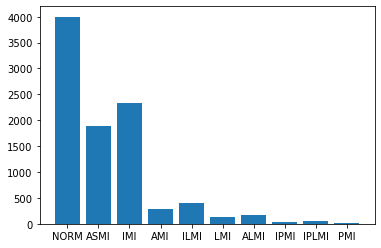

In [5]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH OF THE CLASSES PRESENT IN THE DATASET
my_dict = Counter(collect_and_label('ptbxl_database.csv')['label'])
keys = my_dict.keys()
values = my_dict.values()

plt.bar(keys, values)

In [6]:
def div_and_label(dataframe):   # dataframe = df_new, function returns X and y (labelled).
    
    # does the one-hot encoding of the labels and assigns them numbers between 0 to 9.
    
    X = dataframe[['ecg_id', 'filename_hr']]   #using the higher sampling frequency 
    X = X.to_numpy()
    y = dataframe['label']
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_y = encoder.transform(y)
    
    return (X, encoded_y)

In [7]:
def balance_dat(X_in, y_in):    # X_in = X, y_in = encoded_y
    
    # balances the dataset to make each class have 1000 instances.
    
    smote_nc = SMOTENC(categorical_features=[1], random_state = 0)
    X_res, y_res = smote_nc.fit_resample(X_in, y_in)
    X_del = np.delete(X_res, 0, 1)
    
    return (X_del, y_res)

In [8]:
# collecting the values of input and target (obtained so far) in these variables as shown below, for further use.

alpha = collect_and_label('ptbxl_database.csv')   # the database file is imported to the jupyter notebook itself.
beta0, beta1 = div_and_label(alpha)
gamma0, gamma1 = balance_dat(beta0, beta1)

print(gamma0.shape)
print(gamma1.shape)

(40000, 1)
(40000,)


<BarContainer object of 10 artists>

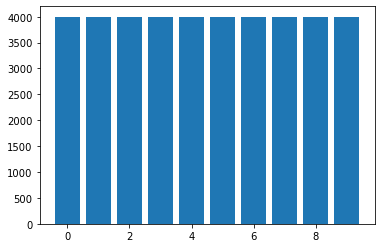

In [9]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH OF THE CLASSES AFTER THE AUGMENTATION AND BALANCING(OVER SAMPLING)

my_dict1 = Counter(gamma1)
keys1 = my_dict1.keys()
values1 = my_dict1.values()

plt.bar(keys1, values1)

In [10]:
def records_tt_split(Xin, yin):   # Xin = gamma0, yin = gamma1
    
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)    # 75%-25% split.
    
    skf.get_n_splits(Xin, yin)
    
    for train_index, test_index in skf.split(Xin, yin):
        X_train, X_test = Xin[train_index], Xin[test_index]
        y_train, y_test = yin[train_index], yin[test_index]
        
    return (X_train, X_test, y_train, y_test)

In [11]:
from scipy import signal
import matplotlib.pyplot as plt

In [12]:
# intialize global lists
final_list_X = []  # would contain lists of all 36 features extracted from the ECG beats
final_list_y = []  # would contain corresponding labels to the beats (0-9)

def load_raw_data(feat_inp, targ_inp):
    # feat_inp = gamma0, targ_inp = gamma1
    
    path = r'C:\Users\harsh raj\OneDrive\Desktop\Research_Project\ptb-xl-dataset-1.0.1'
    temp = feat_inp
    new_arr = np.reshape(temp, temp.shape[0])    # reshaping gamma0 (X_del) to an 1D array to make 'in' command work well.
    
    record_no = 0
    
    for f in new_arr:
        signal, meta_val = wfdb.rdsamp(path + '/' + f)   # signal.shape = (5000, 12)
        value = signal.T
        temp_list = []
        flag1 = -1
        
        for ind in range(12):
            val_ind = value[ind]
            tmpp = val_ind.shape[0]
            val_ind = val_ind.reshape(1, tmpp)
            val_filtered = filter_data(val_ind)
            val_filtered = val_filtered.reshape(val_filtered.shape[1], )  # converting (1, 5000) to (5000, ) i.e., 1-D array
            a_var = return_peaks(val_filtered)
            
            if(a_var == 'INCOMPLETE'):
                temp_list = []
                flag1 = 1
                break
            
            temp_list.append(a_var[0])
            temp_list.append(a_var[1])
            temp_list.append(a_var[2])
        
        
        if(flag1 == -1):
            final_list_X.append(temp_list)
            final_list_y.append(targ_inp[record_no])
        
        record_no = record_no + 1


In [13]:
def filter_data(val):
    
    ecg = val 
    Fs = 500  # sampling frequency of the ECG signal.
    N = ecg.shape[1]
    t = ((np.linspace(0, N-1, N))/(Fs))
    cover = t.shape[0]
    t = t.reshape(1, cover)   # t must be of the same shape as xn.
    n=2    # order of filter.

    Fcutoff_low = 0.5 
    Wn_low = ((2*Fcutoff_low)/(Fs))
    b_low, a_low = signal.butter(n, Wn_low, 'low')
    xn_filtered_LF = signal.filtfilt(b_low, a_low, ecg)

    Fcutoff_high = 40 
    Wn_high = ((2*Fcutoff_high)/(Fs))
    b_high, a_high = signal.butter(n, Wn_high, 'high')
    xn_filtered_HF = signal.filtfilt(b_high, a_high, ecg)

    xn = (ecg-xn_filtered_HF-xn_filtered_LF)
    
    return xn

In [14]:
import neurokit2 as nk
import biosppy
from statistics import mean

In [15]:
def return_peaks(ecg_test):
    
    ''' clean the signal further with the neurokit '''

    cleaned = nk.ecg_clean(ecg_test, sampling_rate = 500)  


    ''' Detect the R-peaks for that lead '''

    rdet, = biosppy.ecg.hamilton_segmenter(signal = cleaned, sampling_rate = 500)   
    rdet, = biosppy.ecg.correct_rpeaks(signal = cleaned, rpeaks = rdet, sampling_rate = 500, tol = 0.05)
    
    if(rdet.size<=4):        # when just 4 or less rpeaks are found, there's no point of considering that whole record at all.
        return 'INCOMPLETE'
    
    rdet = np.delete(rdet, -1)       # remove the last R-peak to avoid the invalid detection for S and T peaks.
    rdet = np.delete(rdet, 0)        # remove the first R-peak to avoid the invalid detection for P and Q peaks.
    rpeaks = {'ECG_R_Peaks': rdet}    # created this dictionary to use it for the future use.

    ''' remove the baseline wander from the ECG lead '''

    cleaned_base = nk.signal_detrend(cleaned, order=0)

    ''' The features to be extracted are Q-wave amplitude, T-wave amplitude, and ST deviation.
                   (a) ST-deviation = (value of cleaned_base at QRS onset - value of cleaned_base at QRS offset).
                   (b) T amplitude = value of cleaned_base at the position of T peak.
                   (c) Q amplitude = value of cleaned_base at the position of Q peak. '''


    ''' ECG delineation using 'dwt' method for (i) T-Peak detection, (ii) QRS wave onsets and offsets: '''

    signals, waves = nk.ecg_delineate(cleaned_base, rpeaks, sampling_rate = 500, method = "dwt") 


    ''' ECG delineation using 'peak' method for Q-Peak detection. '''

    ''' for the peak detection using 'peak' method, we must have atleast 4 R-Peaks otherwise it shows an
     error due to incompatibility and then we won't be able to extract the time domain features. In that case,
     either we remove the complete ECG record or we keep on appending the array for the rpeaks (rpeaks['ECG_R_Peaks']) with the 
     last rpeak position until it's size becomes atleast 4.'''

    rpeakss = rpeaks.copy()  #just store the rpeaks in some other variable. .copy() is used to prevent the similar changes in rpeaks
    temppo = 4-len(rpeakss['ECG_R_Peaks'])

    if temppo>0:

        for i in range(temppo):
            rpeakss['ECG_R_Peaks'] = np.append(rpeakss['ECG_R_Peaks'], rpeakss['ECG_R_Peaks'][-1] + 1)


    signals1, waves1 = nk.ecg_delineate(cleaned_base, rpeakss, sampling_rate = 500, method = "peak")

    # To get the original Q peaks' positions, we remove the irrelevant ones.
    if temppo>0:
        for j in range(temppo):
            waves1['ECG_Q_Peaks'] = waves1['ECG_Q_Peaks'][:-1] #remove the last element by slicing.(waves1['ECG_Q_Peaks'] is a list)
            
    list1 = []     # stores all the ST-deviations from all the beats of the input lead. 
    list2 = []     # stores all the T peaks from all the beats of the input lead.
    list3 = []     # stores all the Q peaks from all the beats of the input lead.
    
    for some1 in range(len(waves['ECG_R_Onsets'])):
        if((np.isnan(waves['ECG_R_Onsets'][some1])) or (np.isnan(waves['ECG_R_Offsets'][some1]))):
            continue
        else:
            list1.append(cleaned_base[waves['ECG_R_Onsets'][some1]] - cleaned_base[waves['ECG_R_Offsets'][some1]])
            
    
    for some2 in range(len(waves['ECG_T_Peaks'])):
        if(np.isnan(waves['ECG_T_Peaks'][some2])):
            continue
        else:
            list2.append(cleaned_base[waves['ECG_T_Peaks'][some2]])
        
    
    for some3 in range(len(waves1['ECG_Q_Peaks'])):
        if(np.isnan(waves1['ECG_Q_Peaks'][some3])):
            continue
        else:
            list3.append(cleaned_base[waves1['ECG_Q_Peaks'][some3]])
            
    if((len(list1)==0) or (len(list2)==0) or (len(list3)==0)):
        return 'INCOMPLETE'
    
    return (mean(list1), mean(list2), mean(list3))     # return the average values of ST deviations, T peaks, and Q peaks of the input lead.

In [22]:
# For an example, the 'waves' obtained from the function return_peaks would look like as shown below.
'waves'

{'ECG_T_Peaks': [499,
  766,
  1030,
  1294,
  1565,
  1834,
  2108,
  2378,
  2645,
  2918,
  3201,
  3478,
  3749,
  4026,
  4302,
  4597],
 'ECG_T_Onsets': [468,
  738,
  995,
  1261,
  1533,
  1801,
  2081,
  2345,
  2614,
  2884,
  3165,
  3446,
  3715,
  3997,
  4273,
  4565],
 'ECG_T_Offsets': [535,
  800,
  1068,
  1329,
  1604,
  1871,
  2145,
  2417,
  2682,
  2953,
  3238,
  3512,
  3788,
  4061,
  4337,
  4639],
 'ECG_P_Peaks': [231,
  499,
  838,
  1032,
  1294,
  1566,
  1835,
  2186,
  2378,
  2646,
  2919,
  3202,
  3557,
  3834,
  4026,
  4302],
 'ECG_P_Onsets': [186,
  462,
  826,
  992,
  1257,
  1527,
  1798,
  2166,
  2340,
  2610,
  2880,
  3159,
  3541,
  3807,
  3985,
  4259],
 'ECG_P_Offsets': [264,
  535,
  867,
  1068,
  1329,
  1604,
  1871,
  2215,
  2417,
  2682,
  2953,
  3238,
  3587,
  3869,
  4061,
  4337],
 'ECG_R_Onsets': [363,
  578,
  916,
  1179,
  1450,
  1648,
  1968,
  2263,
  2531,
  2802,
  3059,
  3332,
  3634,
  3911,
  4187,
  4448],
 'ECG

In [23]:
# For an example, the 'waves1' obtained from the function return_peaks would look like as shown below.
'waves1'

{'ECG_P_Peaks': [309,
  576,
  912,
  1104,
  1375,
  1645,
  nan,
  2186,
  2458,
  2727,
  3011,
  3283,
  3556,
  3834,
  4107,
  4408],
 'ECG_Q_Peaks': [345,
  620,
  931,
  1195,
  1466,
  1679,
  1889,
  2278,
  2546,
  2817,
  3071,
  3343,
  3649,
  3926,
  4202,
  4461],
 'ECG_S_Peaks': [401,
  668,
  1077,
  1355,
  1612,
  1736,
  2008,
  2434,
  2699,
  2968,
  3102,
  3378,
  3803,
  4086,
  4384,
  4496],
 'ECG_T_Peaks': [499,
  767,
  1104,
  1375,
  1645,
  1836,
  2109,
  2458,
  2727,
  3011,
  3202,
  3480,
  3834,
  4107,
  nan,
  4598],
 'ECG_P_Onsets': [263,
  535,
  901,
  1081,
  1358,
  1605,
  nan,
  2170,
  2443,
  2707,
  2953,
  3236,
  3542,
  3807,
  4091,
  4394],
 'ECG_T_Offsets': [535,
  802,
  1137,
  1401,
  1672,
  1864,
  2144,
  2484,
  2752,
  3023,
  3236,
  3507,
  3855,
  4132,
  nan,
  4643]}

In [37]:
# Calling the below function will fill the lists 'final_list_X' and 'final_list_y' => we will get final dataset with beats and
# their features extracted.

load_raw_data(gamma0, gamma1)   

In [19]:
print(len(final_list_X))
print(len(final_list_y))
print(len(final_list_X[0]))

35315
35315
36


In [20]:
Counter(final_list_y)

Counter({2: 3487,
         8: 3553,
         4: 3539,
         1: 3598,
         3: 3555,
         7: 3461,
         0: 3726,
         6: 2896,
         5: 3765,
         9: 3735})

<BarContainer object of 10 artists>

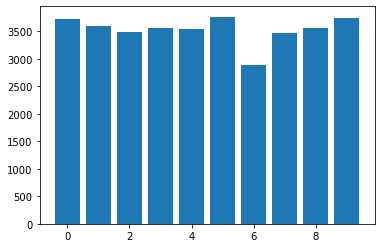

In [21]:
# HISTOGRAM PLOT TO SHOW THE FREQUENCY OF EACH CLASS AFTER EXTRACTING BEATS FROM ECG:

my_dict3 = Counter(final_list_y)
keys3 = my_dict3.keys()
values3 = my_dict3.values()

plt.bar(keys3, values3)

In [26]:
df  = pd.DataFrame(columns = ('ST-1', 'T-1', 'Q-1', 'ST-2', 'T-2', 'Q-2', 'ST-3', 'T-3', 'Q-3', 'ST-4', 'T-4', 'Q-4', 
                              'ST-5', 'T-5', 'Q-5', 'ST-6', 'T-6', 'Q-6', 'ST-7', 'T-7', 'Q-7', 'ST-8', 'T-8', 'Q-8', 
                             'ST-9', 'T-9', 'Q-9', 'ST-10', 'T-10', 'Q-10', 'ST-11', 'T-11', 'Q-11', 'ST-12', 'T-12', 'Q-12', 'Annotations'))


In [27]:
dictt = {0:'ALMI', 1:'AMI', 2:'ASMI', 3:'ILMI', 4:'IMI', 5:'IPLMI', 6:'IPMI', 7:'IMI', 8:'NORM', 9:'PMI'}

for i in range(len(final_list_X)):
    df.loc[i] = final_list_X[i] + [dictt[final_list_y[i]]]

path_csv = r'C:\Users\harsh raj\OneDrive\Desktop'
df.to_csv(path_csv + '/' + 'Extracted_Features.csv')

In [28]:
X_train_array = np.array(final_list_X)

In [29]:
y_train_array = np.array(final_list_y)

In [30]:
print(X_train_array.shape)
print(y_train_array.shape)

(35315, 36)
(35315,)


In [31]:
# reshape the 2D training array into a 3D array before using neural networks.

X_train_array = X_train_array.reshape((X_train_array.shape[0], X_train_array.shape[1], 1))  

In [32]:
print(X_train_array.shape)
print(y_train_array.shape)

(35315, 36, 1)
(35315,)


In [33]:
X_train, X_test, y_train, y_test = records_tt_split(X_train_array, y_train_array)  # train-test split of the overall data.

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(26487, 36, 1)
(8828, 36, 1)
(26487,)
(8828,)


In [35]:
# save these training and testing data as .npy files on the desktop.

path_to_store = r'C:\Users\harsh raj\OneDrive\Desktop'

np.save(path_to_store + '/' + 'XTrain.npy', X_train)

In [36]:
np.save(path_to_store + '/' + 'XTest.npy', X_test)
np.save(path_to_store + '/' + 'yTrain.npy', y_train)
np.save(path_to_store + '/' + 'yTest.npy', y_test)